In [1]:
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from statistics import mean
import numpy as np
from distfit import distfit
from scipy.stats import norm
import mplcyberpunk
import seaborn as sns
from matplotlib import pyplot as plt
from functools import partial
from math import ceil

plt.style.use("cyberpunk")

In [2]:
step_size = 0.05
label_size = 18
smoothing = 6
remove_other = True
legend_args = {"prop": {"size": 18}}
title_style = {"fontsize": 28, "weight": "bold"}


In [3]:
gender_mapping = {
    "male": "Male",
    "m": "Male",
    "man": "Male",
    "female": "Female",
    "f": "Female",
}

gender_int_mapping = ["Female", "Male"]

In [4]:
def get_data(path):
    gender_and_ages = list()
    gender_counts = defaultdict(int)
    gender_ratings = list()
    age_ratings = list()

    with open(path) as f:
        data = json.load(f)

    for sample in tqdm(data.values()):
        gender = sample["gender"]

        if not gender:
            gender_int = round(mean(map(lambda x: x["gender"], sample["detections"])))
            gender_val = gender_int_mapping[gender_int]
        else:
            gender_val = gender_mapping.get(gender)

        gender_counts[gender_val] += 1

        ratings = list(filter(None, map(lambda x: x["value"], sample["ratings"])))
        gender_ratings += map(lambda x: (x, gender_val), ratings)

        if age := sample["age"]:
            gender_and_ages.append((gender_val, age))
            age_ratings += map(lambda x: (x, age, gender_val), ratings)

    gender_counts = dict(
        sorted(gender_counts.items(), key=lambda x: x[1], reverse=True)
    )
    gender_rating_df = pd.DataFrame(gender_ratings, columns=["Rating", "Gender"])
    gender_age_df = pd.DataFrame(gender_and_ages, columns=["Gender", "Age"])

    count_df = pd.DataFrame(
        {
            "counts": list(gender_counts.values()),
            "names": list(gender_counts.keys()),
        },
    )

    if remove_other:
        gender_rating_df = gender_rating_df[gender_rating_df["Gender"] != None]
        gender_age_df = gender_age_df[gender_age_df["Gender"] != None]
        count_df = count_df[count_df["names"] != "None"]

    return dict(
        count=count_df,
        gender_age=gender_age_df,
        gender_rating=gender_rating_df,
        age_rating=age_ratings,
    )


In [5]:
truerateme = get_data("data/truerateme.json")
rateme = get_data("data/Rateme.json")

100%|██████████| 17381/17381 [00:00<00:00, 49577.98it/s]


In [6]:
def absolute_value(total, val):
    a = np.round(val / 100.0 * total, 0)
    return f"{int(a)}\n({val:.1f}%)"


def plot_gender_ratio(ax, count_df):
    total = count_df["counts"][:2].sum()
    _, _, texts = ax.pie(
        count_df["counts"][:2],
        labels=count_df["names"][:2],
        autopct=partial(absolute_value, total),
        explode=[0.05] * 2,
        textprops={"color": "white", "size": label_size, "weight": "bold"},
        shadow=True,
    )
    for t in texts:
        t.set_c("black")
    ax.set_title("Gender distribution")


def plot_age_distribution(ax, gender_age_df, clip, legend=True):
    male_age = gender_age_df[gender_age_df["Gender"] == "Male"].Age
    female_age = gender_age_df[gender_age_df["Gender"] == "Female"].Age

    sns.kdeplot(male_age, label="Male", clip=clip, ax=ax)
    sns.kdeplot(female_age, label="Female", clip=clip, ax=ax)
    if legend:
        ax.legend(**legend_args)
    ax.set_xticks(np.arange(*clip, 5))
    ax.set(ylabel=None, xlabel=None)

    mplcyberpunk.make_lines_glow(ax)


In [7]:
def plot_age_rating(ax, age_ratings, min_age=10, max_age=60, legend=True, loc=0):
    age_rating_df = pd.DataFrame(age_ratings, columns=["Rating", "Age", "Gender"])
    age_rating_df = age_rating_df[
        (age_rating_df.Age >= min_age) & (age_rating_df.Age <= max_age + 1)
    ]

    sns.lineplot(
        ax=ax, data=age_rating_df, x="Age", y="Rating", hue="Gender", legend=legend
    )

    ax.set_xticks(np.arange(min_age, max_age + 1, 5))
    ax.set_yticks(np.arange(0, 11))
    ax.set_ylabel("Rating", fontsize=label_size)
    ax.set_xlabel("Age", fontsize=label_size)
    if legend:
        ax.legend(loc=loc, **legend_args)
    mplcyberpunk.make_lines_glow(ax)


In [8]:
def plot_rating_distribution(
    ax, perfect, data, estimated, gender, dist_name, legend=True, loc=0
):
    ax.plot(
        np.arange(0, 10, step_size),
        estimated,
        label=f"Estimated {dist_name} distribution",
    )
    sns.kdeplot(data, label="Real data", ax=ax, clip=(0, 10), legend=False)

    if perfect is not None:
        ax.plot(
            np.arange(0, 10, step_size), perfect, label="Perfect normal distribution"
        )

    ax.set_xticks(np.arange(0, 11, 1))
    ax.set(ylabel=None, xlabel=None)
    ax.set_title(
        f"{gender} ratings", fontdict={"fontsize": 18, "weight": "bold"}, pad=20
    )
    if legend:
        ax.legend(loc="upper left", **legend_args)
    ax.set_xlim([0, 10])
    mplcyberpunk.make_lines_glow(ax)


def plot_distribution(gender_rating_df, axes, plot_perfect=False):
    all_dists = []

    for i, gender in enumerate(["Male", "Female"]):
        mask = gender_rating_df["Gender"] == gender
        ratings = gender_rating_df[mask]["Rating"].to_numpy()

        dist = distfit(smooth=smoothing)
        dist.fit_transform(ratings)
        dist_df = dist.summary
        best = dist.model
        all_dists.append(best["model"])

        if plot_perfect:
            normal = dist_df[dist_df["distr"] == "norm"].iloc[0]

            estimated_normal = norm.pdf(
                np.arange(0, 10, step_size), normal["loc"], normal["scale"]
            )
            perfect = norm.pdf(np.arange(0, 10, step_size), 5, 1)

            plot_rating_distribution(
                axes[0][i],
                perfect,
                ratings,
                estimated_normal,
                gender,
                "normal",
                i == 0,
                loc="upper left",
            )
        else:
            estimated = best["model"].pdf(np.arange(0, 10, step_size))
            plot_rating_distribution(
                axes[0][i],
                None,
                ratings,
                estimated,
                gender,
                best["name"],
                i == 0,
                loc="upper left",
            )

    return all_dists


In [9]:
def plot_gender_rating_translation(ax, male_dist, female_dist):
    male_cdf = male_dist.cdf(np.arange(0, 10, step_size))
    female_ratings = female_dist.ppf(male_cdf)
    ax.plot(
        np.arange(0, 10, step_size),
        np.arange(0, 10, step_size),
        "--",
        label="1 to 1 mapping",
        dashes=(4, 3),
    )
    ax.plot(
        np.arange(0, 10, step_size),
        female_ratings,
        label="Male to female rating translation",
    )

    ax.set_yticks(np.arange(0, 11, 1))
    ax.set_xticks(np.arange(0, 11, 1))
    ax.set
    ax.set_ylabel("Female rating", fontsize=label_size)
    ax.set_xlabel("Male rating", fontsize=label_size)
    ax.set_title(
        "/r/Rateme male to female rating translation",
        fontdict={"fontsize": 18, "weight": "bold"},
        pad=20,
    )
    ax.legend(**legend_args,loc='upper left')
    mplcyberpunk.make_lines_glow(ax)


In [10]:
def plot_rating_translation(ax, truerateme, rateme):
    truerateme_ratings = truerateme["gender_rating"].Rating.to_numpy()
    rateme_ratings = rateme["gender_rating"].Rating.to_numpy()

    truerateme_dist = distfit(smooth=smoothing).fit_transform(truerateme_ratings)[
        "model"
    ]["model"]
    rateme_dist = distfit(smooth=smoothing).fit_transform(rateme_ratings)["model"][
        "model"
    ]

    cdf = truerateme_dist.cdf(np.arange(0, 10, step_size))
    ppf = rateme_dist.ppf(cdf)
    ax.plot(
        np.arange(0, 10, step_size),
        np.arange(0, 10, step_size),
        "--",
        dashes=(4, 3),
        label="1 to 1 mapping",
    )
    ax.plot(
        np.arange(0, 10, step_size),
        ppf.clip(0, 10),
        label="truerateme to rateme translation",
    )
    ax.legend(**legend_args)
    ax.set_ylabel("Rateme", fontsize=label_size)
    ax.set_xlabel("truerateme", fontsize=label_size)

    ax.set_yticks(np.arange(0, 11, 1))
    ax.set_xticks(np.arange(0, 11, 1))
    ax.set_title(
        "Rateme to truerateme rating translation",
        fontdict={"fontsize": 18, "weight": "bold"},
        pad=20,
    )
    mplcyberpunk.make_lines_glow(ax)


In [11]:
def add_centered_title(ax, row, title,**kwargs):
    new = fig.add_subplot(ax.get_gridspec()[row, :], frameon=False)
    new.set_yticks([])
    new.set_xticks([])
    new.set_title(title, fontdict=title_style,**kwargs)


[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.1888830] [loc=6.579 scale=2.032]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.6469772] [loc=0.050 scale=6.529]
[distfit] >[pareto    ] [1.70 sec] [RSS: 0.6320976] [loc=-186388815.256 scale=186388815.306]
[distfit] >[dweibull  ] [0.24 sec] [RSS: 0.2153832] [loc=6.638 scale=1.801]
[distfit] >[t         ] [0.68 sec] [RSS: 0.1888814] [loc=6.579 scale=2.032]
[distfit] >[genextreme] [0.47 sec] [RSS: 0.1768055] [loc=6.054 scale=2.188]
[distfit] >[gamma     ] [0.86 sec] [RSS: 0.1928013] [loc=-24.692 scale=0.137]
[distfit] >[lognorm   ] [1.74 sec] [RSS: 0.1935955] [loc=-89.109 scale=95.637]
[distfit] >[beta      ] [0.48 sec] [RSS: 0.1829051] [loc=-0.081 scale=10.380]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.4235642] [loc=0.050 scale=9.950]
[distfit] >[loggamma  ] [0.16 sec] [RSS: 0.1804488] [loc=2.696 scale=3.546]
[distfit] >Compute confidence interval [parametric]
[dist

<Figure size 432x288 with 0 Axes>

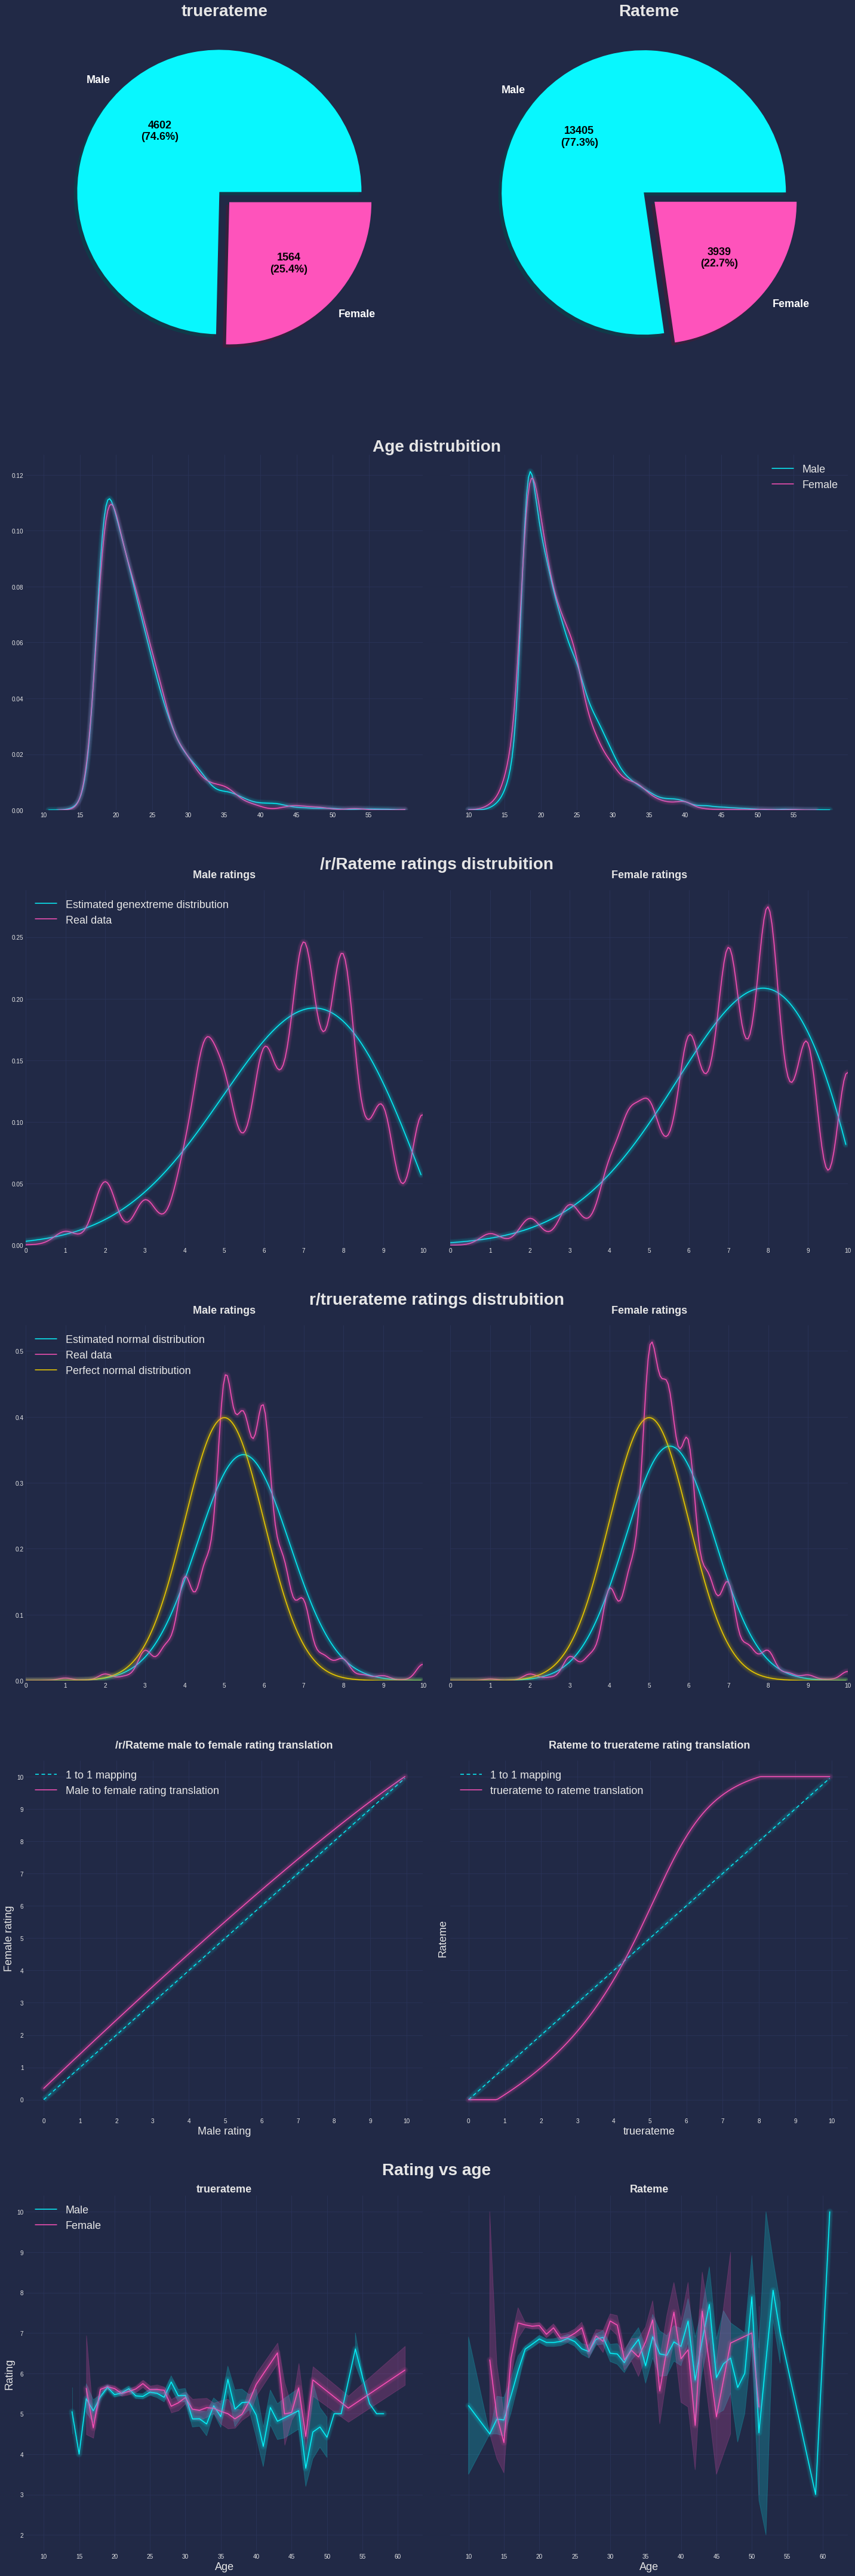

In [12]:
plt.set_cmap('spring')

fig, (
    (ax1, ax2),
    (ax3, ax4),
    (ax5, ax6),
    (ax7, ax8),
    (ax9, ax10),
    (ax11, ax12),
) = plt.subplots(ncols=2, nrows=6, figsize=(20, 60), sharex="row", sharey="row")

plot_gender_ratio(ax1, truerateme["count"])
plot_gender_ratio(ax2, rateme["count"])

ax1.set_title("truerateme", fontdict=title_style)
ax2.set_title("Rateme", fontdict=title_style)

add_centered_title(ax1, 1, "Age distrubition")

plot_age_distribution(ax3, truerateme["gender_age"], (10, 60), legend=False)
plot_age_distribution(ax4, rateme["gender_age"], (10, 60))

add_centered_title(ax1, 2, "/r/Rateme ratings distrubition", pad=35)

male_dist, female_dist = plot_distribution(rateme["gender_rating"], [(ax5, ax6)])
plot_distribution(
    truerateme["gender_rating"],
    [
        (ax7, ax8),
    ],
    plot_perfect=True,
)

add_centered_title(ax1, 3, "r/truerateme ratings distrubition", pad=35)

plot_gender_rating_translation(ax9, male_dist, female_dist)
plot_rating_translation(ax10, truerateme, rateme)

plot_age_rating(ax11, truerateme["age_rating"], loc=2)
ax11.set_title("truerateme", fontdict={"fontsize": 18, "weight": "bold"})
plot_age_rating(ax12, rateme["age_rating"], legend=False)
ax12.set_title("Rateme", fontdict={"fontsize": 18, "weight": "bold"})

add_centered_title(ax1, 5, "Rating vs age", pad=35)

plt.tight_layout(h_pad=2.5, w_pad=2.5)
plt.savefig("poster.jpg",pad_inches=2)